In [1]:
from collections import OrderedDict

import matplotlib.pyplot as plt
import numpy as np
import shapely
from skfem import Basis, ElementDG, ElementTriP1
from skfem.io import from_meshio

from femwell.mesh import mesh_from_OrderedDict
from femwell.mode_solver_2d_periodic import plot_periodic, solve_periodic


In [3]:
# [1] Jelena Notaros and Miloš A. Popović. Finite-difference complex-wavevector band structure solver 
# for analysis and design of periodic radiative microphotonic structures. Optics Letters, 40(6):1053, 
# March 2015. URL: https://doi.org/10.1364/ol.40.001053, doi:10.1364/ol.40.001053.

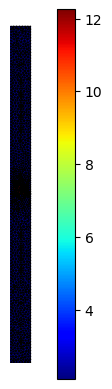

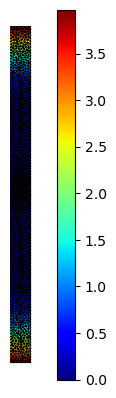

C:\Users\blow\AppData\Local\anaconda3\Lib\site-packages\scipy\sparse\linalg\_dsolve\linsolve.py:395: SparseEfficiencyWarning: splu converted its input to CSC format
  warn('splu converted its input to CSC format', SparseEfficiencyWarning)
C:\Users\blow\AppData\Local\anaconda3\Lib\site-packages\scipy\sparse\linalg\_dsolve\linsolve.py:285: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  warn('spsolve is more efficient when sparse b '


[10.52113488+0.09821967j]


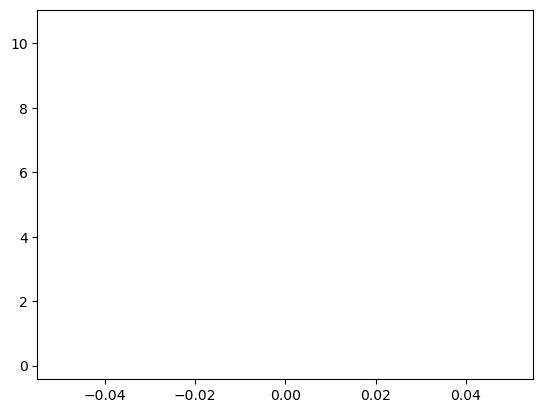

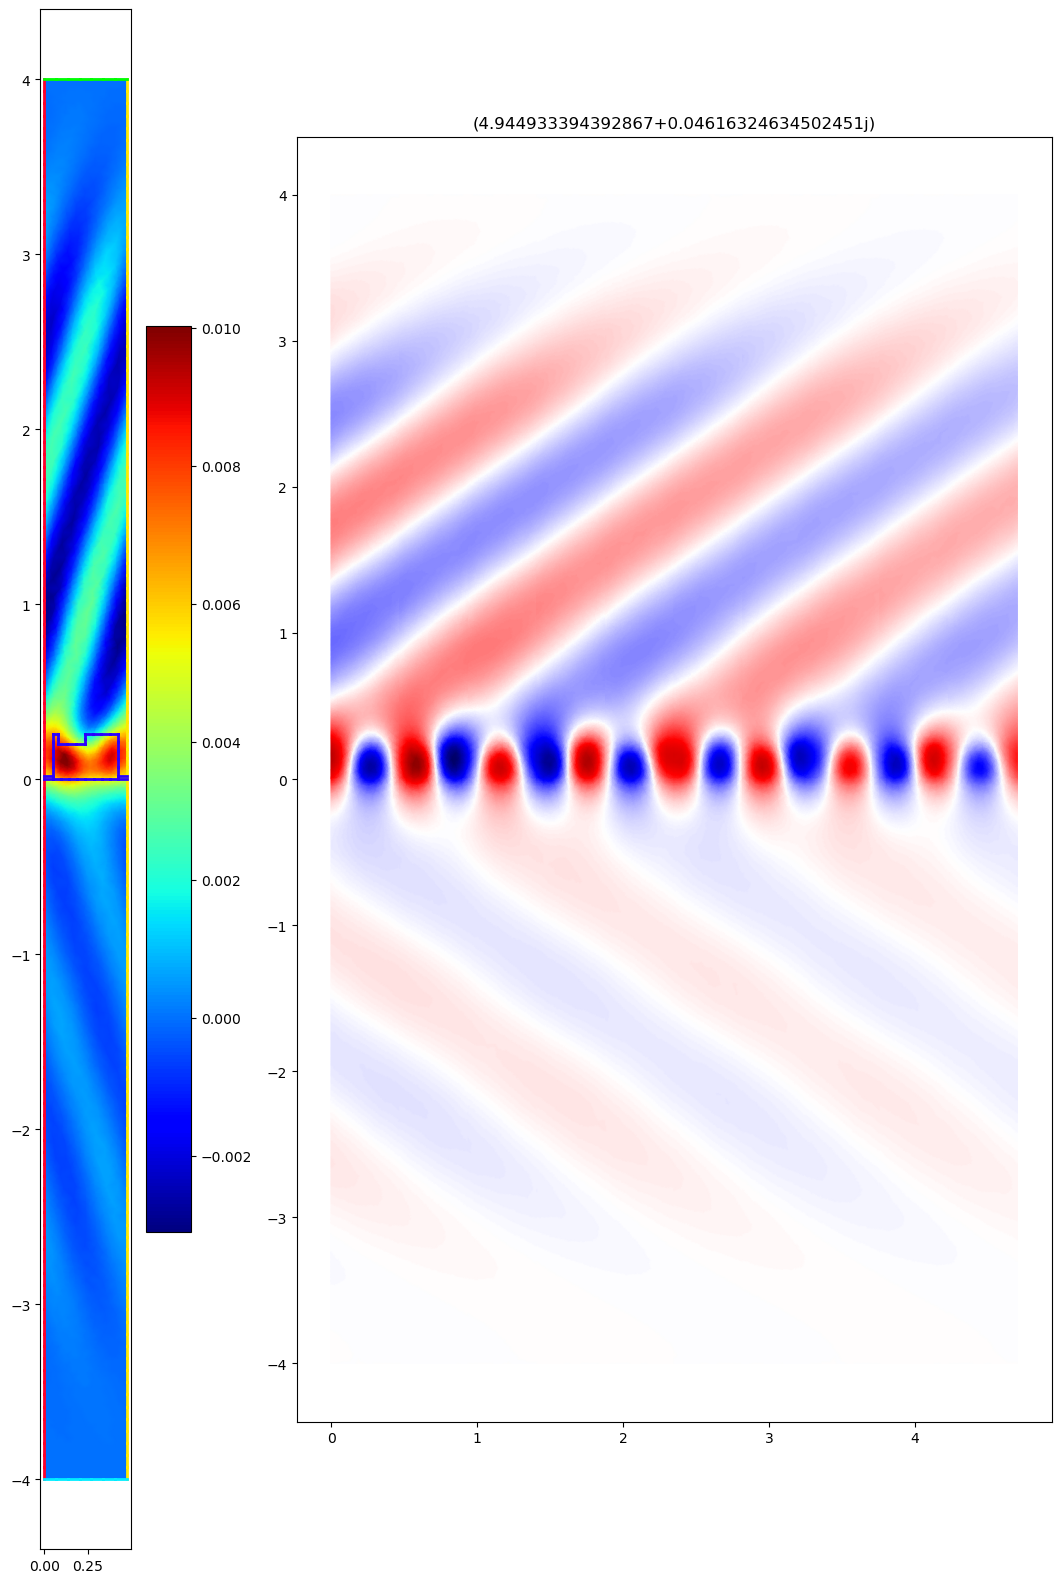

In [8]:
height = 4
h1 = 0.26
h2 = 0.2
h3 = 0.02

a = 0.47
w1 = 0.1
w2 = 0.03
w3 = 0.15

pml = 2

k0 = 1.9 / a  # 1.05/a

left = shapely.LineString([(0, y) for y in np.linspace(-height, height, 2)])
right = shapely.LineString([(a, y) for y in np.linspace(-height, height, 2)])
top = shapely.LineString([(x, height) for x in np.linspace(0, a, 2)])
bottom = shapely.LineString([(x, -height) for x in np.linspace(0, a, 2)])

background = shapely.box(0, -height, a, height)
structure = shapely.Polygon(
    (
        (0, 0),
        (0, h3),
        (w1 / 2, h3),
        (w1 / 2, h1),
        (w1 / 2 + w2, h1),
        (w1 / 2 + w2, h2),
        (w1 / 2 + w2 + w3, h2),
        (w1 / 2 + w2 + w3, h1),
        (a - w1 / 2, h1),
        (a - w1 / 2, h3),
        (a, h3),
        (a, 0),
    )
)

resolutions = {"structure": {"resolution": 0.05, "distance": 0.5}}

mesh = from_meshio(
    mesh_from_OrderedDict(
        OrderedDict(
            left=left,
            right=right,
            top=top,
            bottom=bottom,
            structure=structure,
            background=background,
        ),
        resolutions=resolutions,
        filename="mesh.msh",
        default_resolution_max=0.07,
        periodic_lines=[("left", "right")],
    )
)

basis_epsilon_r = Basis(mesh, ElementDG(ElementTriP1()), intorder=4)

epsilon_r = basis_epsilon_r.zeros(dtype=np.complex64) + 1.45
epsilon_r[basis_epsilon_r.get_dofs(elements="structure")] = 3.5
epsilon_r **= 2
epsilon_r += basis_epsilon_r.project(
    lambda x: (4j) * (np.clip(np.abs(x[1]) - height + pml, 0, np.inf) / pml) ** 2,
    dtype=np.complex64,
)
basis_epsilon_r.plot(np.real(epsilon_r), ax=mesh.draw(), colorbar=True).show()
basis_epsilon_r.plot(np.imag(epsilon_r), ax=mesh.draw(), colorbar=True).show()

ks, basis_phi, phis = solve_periodic(basis_epsilon_r, epsilon_r, k0)


idx = (np.abs(np.imag(ks * a)) < 0.1) * (np.abs(np.real(ks * a)) < 7)
ks = ks[idx]
phis = phis[:, idx]

print(ks)

plt.plot(np.real(ks))
plt.plot(np.imag(ks))
plt.show()

for i, k in enumerate(ks):
    fig, axs = plt.subplots(1, 2, figsize=(15, 20), gridspec_kw={"width_ratios": [4, 10]})
    mesh.draw(ax=axs[0], boundaries=True, boundaries_only=True)
    basis_phi.plot(np.real(phis[..., i]), shading="gouraud", colorbar=True, ax=axs[0])
    axs[0].set_aspect(1)
    plt.title(f"{k*a}")
    # axs[0].set_aspect(1)
    plot_periodic(k, a, basis_phi, phis[..., i], 10, axs[1])
    plt.show()